In [185]:
# %pip install datasets
# %pip install Pillow
# %pip install numpy
# %pip install matplotlib
# %pip install import_ipynb
# %pip install tensorflow
# %pip install tensorflow.keras
# %pip install easyocr
# %pip install pandas

# # library from etl
# %pip install datasets
# %pip install numpy
# %pip install Pillow
# %pip install opencv-python
# %pip install json

In [186]:
import easyocr
import matplotlib.pyplot as plt
from datasets import load_dataset
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
# from tensorflow.keras import layers
import json
import pandas as pd

In [187]:
from kaggle_secrets import UserSecretsClient
import os

# Ambil GitHub token dari Kaggle Secrets
user_secrets = UserSecretsClient()
myGithub = user_secrets.get_secret("githubKey")

# Clone repo GitHub
!git clone https://{myGithub}@github.com/fitristachan/invoice-image-processing.git invoice_image_processing
!git -C invoice_image_processing pull

fatal: destination path 'invoice_image_processing' already exists and is not an empty directory.
Already up to date.


In [188]:
# from google.colab import userdata

# # Retrieve the GitHub token from userdata
# myGithub = userdata.get('githubKey')

# !git clone https://{myGithub}@github.com/fitristachan/invoice-image-processing.git /content/invoice_image_processing
# !git -C invoice_image_processing pull



In [189]:
# import sys
# import os

# sys.path.append('/content/invoice-image-processing')
# print(os.listdir('/content/invoice-image-processing'))

# !jupyter nbconvert --to script '/content/invoice-image-processing/data_etl_invoice.ipynb' --output data_etl

Image Classification

In [190]:
from invoice_image_processing.data_etl import DatasetReceipt

In [192]:
from datasets import concatenate_datasets
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from typing import List

# Load individual datasets
train_cord = DatasetReceipt("naver-clova-ix/cord-v2", "train")
val_cord = DatasetReceipt("naver-clova-ix/cord-v2", "validation")
train_donut = DatasetReceipt("katanaml-org/invoices-donut-data-v1", "train")
val_donut = DatasetReceipt("katanaml-org/invoices-donut-data-v1", "validation")

class CombinedReceiptDataset(Dataset):
    def __init__(self, datasets: List[DatasetReceipt]):
        self.samples = []
        for d in datasets:
            self.samples.extend([d[i] for i in range(len(d))])  # langsung ambil hasil akhir dari DatasetReceipt

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        img = sample["image"]
        # if img.dtype != np.float32:
        #     img = img.astype(np.float32) / 255.0  # normalisasi jika belum

        return {
            "image": torch.tensor(img, dtype=torch.float32),
            "quantities": sample["quantities"],  # tetap list of strings
            "prices": sample["prices"],          # tetap list of strings
            "total_price": sample["total_price"],# tetap string
            "item_names": sample["item_names"],  # tetap list of strings
        }

train_dataset = CombinedReceiptDataset([train_cord, train_donut])
val_dataset = CombinedReceiptDataset([val_cord, val_donut])

# Verifikasi
sample = train_dataset[0]
print(f"Image shape: {sample['image'].shape}")  # Harusnya [3, 600, 600]
print(f"Image type: {type(sample['image'])}")  # torch.Tensor

print(f"Total data train CORD: {len(train_cord)}")
print(f"Total data train Donut: {len(train_donut)}")
print(f"Total data train: {len(train_dataset)}")
print(f"Total data validasi: {len(val_dataset)}")

# Verifikasi jumlah harus sama dengan penjumlahan
assert len(train_dataset) == len(train_cord) + len(train_donut), "Jumlah data tidak sesuai!"

Image shape: torch.Size([600, 600, 3])
Image type: <class 'torch.Tensor'>
Total data train CORD: 800
Total data train Donut: 425
Total data train: 1225
Total data validasi: 150


In [193]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import string

# Define a character set
characters = string.ascii_letters + string.digits + " -.:,"
char_to_index = {c: i + 1 for i, c in enumerate(characters)}  # index 0 reserved for padding
index_to_char = {i + 1: c for i, c in enumerate(characters)}
vocab_size = len(characters) + 1

def encode_text(text, max_length):
    encoded = np.zeros(max_length, dtype=np.int32)
    for i, c in enumerate(text[:max_length]):
        encoded[i] = char_to_index.get(c, 0)
    return encoded

def dataset_generator(dataset, batch_size=16, max_items=10, max_name_length=20, max_num_length=20):
    while True:
        batch_types = []
        batch_images = []
        batch_names = []
        batch_quantities = []
        batch_prices = []
        batch_totals = []

        for _ in range(batch_size):
            sample = dataset[np.random.randint(len(dataset))]
            img = sample["image"]

            img = tf.convert_to_tensor(img, dtype=tf.float32)
            img = tf.image.random_brightness(img, max_delta=0.05)
            img = tf.image.random_contrast(img, lower=0.95, upper=1.05)
            img = img.numpy()
            batch_images.append(img)

            doc_type = 0
            if "donut" in sample.get("doc_type", "").lower():
                doc_type = 0
            batch_types.append(doc_type)

            padded_names = np.zeros((max_items, max_name_length), dtype=np.int32)
            padded_quantities = np.zeros((max_items, max_num_length), dtype=np.int32)
            padded_prices = np.zeros((max_items, max_num_length), dtype=np.int32)
            padded_total = np.zeros((1, max_num_length), dtype=np.int32)

            if "item_names" in sample and len(sample["item_names"]) > 0:
                item_names = sample["item_names"]
                quantities = sample.get("quantities", ["0"] * len(item_names))
                prices = sample.get("prices", ["0"] * len(item_names))
                total_price = sample.get("total_price", "0")

                n_items = min(len(item_names), max_items)
                for i in range(n_items):
                    padded_names[i] = encode_text(str(item_names[i]), max_name_length)
                    padded_quantities[i] = encode_text(str(quantities[i]), max_num_length)
                    padded_prices[i] = encode_text(str(prices[i]), max_num_length)

                padded_total[0] = encode_text(str(total_price), max_num_length)

            batch_names.append(padded_names)
            batch_quantities.append(padded_quantities)
            batch_prices.append(padded_prices)
            batch_totals.append(padded_total)

        batch_images = np.array(batch_images, dtype=np.float32)
        batch_types = np.array(batch_types, dtype=np.float32)
        batch_names = to_categorical(batch_names, num_classes=vocab_size)
        batch_quantities = to_categorical(batch_quantities, num_classes=vocab_size)
        batch_prices = to_categorical(batch_prices, num_classes=vocab_size)
        batch_totals = to_categorical(batch_totals, num_classes=vocab_size)

        yield (
            {
                "image_input": batch_images,
                "type_input": batch_types
            },
            {
                "item_name": batch_names,
                "quantity_final": batch_quantities,
                "price_final": batch_prices,
                "total_price": batch_totals
            }
        )

In [194]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Lambda, LSTM, Dense, TimeDistributed, 
                                    RepeatVector, Concatenate, Input)
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
import tensorflow as tf

# Constants
NUM_CHAR_CLASSES = 122
STEPS_PER_EPOCH = 1000
EPOCH = 5
INITIAL_LR = 1e-4
MOMENTUM = 0.9
GRADIENT_CLIP_NORM = 1.0
STD_DEV = 0.01

# 1. Input Layers
image_input = Input(shape=(600, 600, 3), name="image_input")
type_input = Input(shape=(1,), name="type_input")  # Suggestion 4
max_items=10
max_name_length=20
max_num_length=20
#doc type 1 = cord

# 2. Base Model
base_model = ResNet50V2(
    input_shape=(600, 600, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
base_model.trainable = False
image_features = base_model(image_input)

merged = Concatenate()([image_features, type_input])

x = Dense(512, activation='relu', 
        kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01))(merged)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

sequence_input = tf.keras.layers.RepeatVector(max_items)(Dense(256, activation='relu')(x))
sequence_output = tf.keras.layers.TimeDistributed(tf.keras.layers.RepeatVector(max_name_length))(sequence_input)
lstm_output = tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(128, return_sequences=True))(sequence_output)
name_output = tf.keras.layers.TimeDistributed(tf.keras.layers.TimeDistributed(Dense(vocab_size, activation='softmax')), name='item_name')(lstm_output)

quantity_output = tf.keras.layers.TimeDistributed(tf.keras.layers.TimeDistributed(Dense(vocab_size, activation='softmax')), name='quantity_final')(
    tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(128, return_sequences=True))(sequence_output))

price_output = tf.keras.layers.TimeDistributed(tf.keras.layers.TimeDistributed(Dense(vocab_size, activation='softmax')), name='price_final')(
        tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(128, return_sequences=True))(sequence_output))

total_sequence_input = tf.keras.layers.RepeatVector(1)(Dense(256, activation='relu')(x))
total_sequence_output = tf.keras.layers.TimeDistributed(tf.keras.layers.RepeatVector(max_num_length))(total_sequence_input)
total_lstm_output = tf.keras.layers.TimeDistributed(tf.keras.layers.LSTM(128, return_sequences=True))(total_sequence_output)
total_output = tf.keras.layers.TimeDistributed(Dense(vocab_size, activation='softmax'), name='total_price')(total_lstm_output)

# 7. Final Model
model = Model(
    inputs=[image_input, type_input],
    outputs=[name_output, quantity_output, price_output, total_output]
)

# 8. Compile with adjusted loss weights
optimizer = Adam(
    learning_rate=INITIAL_LR,
    beta_1=MOMENTUM,
    clipnorm=GRADIENT_CLIP_NORM
)

In [195]:
model.compile(
    optimizer=optimizer,
    loss={
        "item_name": tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        "quantity_final": "mse",
        "price_final": "mse",
        "total_price": "mse",
    },
    metrics={
        "item_name": "accuracy",
        "quantity_final": "mae",
        "price_final": "mae",
        "total_price": "mae",
    },
    loss_weights={
        "item_name": 1.5,
        "quantity_final": 0.8,
        "price_final": 1.0,
        "total_price": 1.2,
    }
)

In [196]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)  │ (None, 600, 600, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50v2 (Functional)   │ (None, 2048)           │     23,564,800 │ image_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ type_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 2049)           │              0 │ resnet50v2[0][0],      │
│ (Concatenate)             │                        │                │ type_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_101 (Dense)         │ (None, 512)            │      1,049,600 │ concatenate_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 512)            │              0 │ dense_101[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_102 (Dense)         │ (None, 512)            │        262,656 │ dropout_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_103 (Dense)         │ (None, 256)            │        131,328 │ dense_102[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_107 (Dense)         │ (None, 256)            │        131,328 │ dense_102[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_48          │ (None, 10, 256)        │              0 │ dense_103[0][0]        │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_50          │ (None, 1, 256)         │              0 │ dense_107[0][0]        │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_104      │ (None, 10, 20, 256)    │              0 │ repeat_vector_48[0][0] │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_111      │ (None, 1, 20, 256)     │              0 │ repeat_vector_50[0][0] │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_105      │ (None, 10, 20, 128)    │        197,120 │ time_distributed_104[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_108      │ (None, 10, 20, 128)    │        197,120 │ time_distributed_104[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_110      │ (None, 10, 20, 128)    │        197,120 │ time_distributed_104[… │
│ (TimeDistributed)    

 Total params: 25,963,280 (99.04 MB)

 Trainable params: 2,398,480 (9.15 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [197]:
from tensorflow.keras.callbacks import (ModelCheckpoint, LearningRateScheduler, 
                                      TensorBoard, CSVLogger, Callback)
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 1. Enhanced Model Checkpoint
checkpoint_path = "/kaggle/working/model_checkpoint_resnet50V2.keras"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_best_only=True,  # Now saving only best model
    monitor='val_loss',  # Monitoring validation loss
    mode='min',
    save_weights_only=False,
    save_freq='epoch',
    verbose=1
)

def lr_schedule(epoch):
    if epoch < 10:
        return 1e-4
    elif epoch < 20:
        return 1e-5
    else:
        return 1e-6

lr_callback = LearningRateScheduler(lr_schedule, verbose=1)

class EnhancedTrainingCallback(Callback):
    def __init__(self, patience=5, min_epoch_for_acc_stop=5):
        super(EnhancedTrainingCallback, self).__init__()
        self.patience = patience
        self.min_epoch_for_acc_stop = min_epoch_for_acc_stop
        self.wait = 0
        self.stopped_epoch = 0
        self.best_loss = float('inf')
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        current_acc = logs.get('item_name_accuracy', 0)
        current_val_acc = logs.get('val_item_name_accuracy', 0)

        # Condition 1: Accuracy >= 95% AND epoch >= min_epoch_for_acc_stop
        if (current_acc >= 0.95 and current_val_acc >= 0.95 and epoch + 1 >= self.min_epoch_for_acc_stop):
            print(f"\nAccuracy reached 95%% and epoch ≥ {self.min_epoch_for_acc_stop}. Stopping training.")
            self.model.stop_training = True
            self.stopped_epoch = epoch
            return
        
        # Condition 2: Loss plateau detection
        current_loss = logs.get('loss', float('inf'))
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nTraining stopped early after {self.patience} epochs without improvement.")
                self.model.stop_training = True
                self.stopped_epoch = epoch

stop_callback = EnhancedTrainingCallback(patience=5)

lr_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-4
)

# 4. CSV Logging (corrected version)
csv_logger = CSVLogger(
    'training_log.csv',
    separator=',',
    append=False  # Change to True if you want to continue previous logs
)

# 5. TensorBoard Integration
tensorboard_callback = TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True,
    write_images=False,
    update_freq='epoch',
    profile_batch=0  # Disable profiling for cleaner logs
)

# Combine all callbacks
final_callbacks = [
    checkpoint_callback,
    lr_callback,
    stop_callback,
    csv_logger,
    tensorboard_callback
]

final_callbacks.append(lr_plateau)

In [198]:
# Data Augmentation
train_generator = dataset_generator(train_dataset)
val_generator = dataset_generator(val_dataset)

In [199]:
# print(model.output_names)
# print(f"Jumlah batch: {len(train_generator)}")
# sample = train_generator[0]  # atau next(iter(train_generator))
# print("Sample batch shape:", sample[0].shape, sample[1])


In [200]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     epochs=EPOCH,
#     validation_data=val_generator,
#     validation_steps=500,  # Adjust based on validation set size
#     callbacks=final_callbacks,
#     verbose=1
# )


Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5


KeyboardInterrupt: 

In [201]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/working/model_checkpoint_resnet50V2.keras", compile=True)

In [205]:
history = model.fit(
    train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=4,
    epochs=EPOCH,
    validation_data=val_generator,
    validation_steps=500,  # Adjust based on validation set size
    callbacks=final_callbacks,
    verbose=1
)


Epoch 5: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - item_name_accuracy: 0.8744 - item_name_loss: 1.8861 - loss: 1.8923 - price_final_loss: 4.0957e-04 - price_final_mae: 0.0016 - quantity_final_loss: 7.8783e-04 - quantity_final_mae: 0.0016 - total_price_loss: 0.0021 - total_price_mae: 0.0037
Epoch 5: val_loss improved from inf to 1.87837, saving model to /kaggle/working/model_checkpoint_resnet50V2.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1005s 949ms/step - item_name_accuracy: 0.8744 - item_name_loss: 1.8861 - loss: 1.8923 - price_final_loss: 4.0957e-04 - price_final_mae: 0.0016 - quantity_final_loss: 7.8784e-04 - quantity_final_mae: 0.0016 - total_price_loss: 0.0021 - total_price_mae: 0.0037 - val_item_name_accuracy: 0.8751 - val_item_name_loss: 1.8734 - val_loss: 1.8784 - val_price_final_loss: 3.7397e-04 - val_price_final_mae: 0.0014 - val_quantity_final_loss: 7.6199e-04 - val_quantity_final_mae: 0.0013 - val_total_price

In [206]:
with open("training_log.csv") as f:
    for i, line in enumerate(f):
        if i == 0: 
            print("Header:", len(line.split(',')), "columns")
        if i == 26:  # Baris 27 (indeks 0-based)
            print("Line 27:", len(line.split(',')), "columns")
            print("Content:", line)
            break

Header: 20 columns


In [208]:
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt

def clean_log_file(path):
    with open(path) as f:
        # Ambil header (baris pertama)
        header = f.readline().strip()
        # Filter baris yang memiliki 12 koma (13 kolom)
        lines = [line.strip() for line in f if line.count(',') == 12]
        
    # Gabungkan header dengan data yang sudah difilter
    cleaned_data = [header] + lines
    return pd.read_csv(StringIO('\n'.join(cleaned_data)))

# Baca dan bersihkan data
try:
    log_data = clean_log_file("training_log.csv")
except Exception as e:
    print(f"Error: {e}")
    # Fallback: baca dengan engine python
    log_data = pd.read_csv("training_log.csv", engine='python', on_bad_lines='warn')

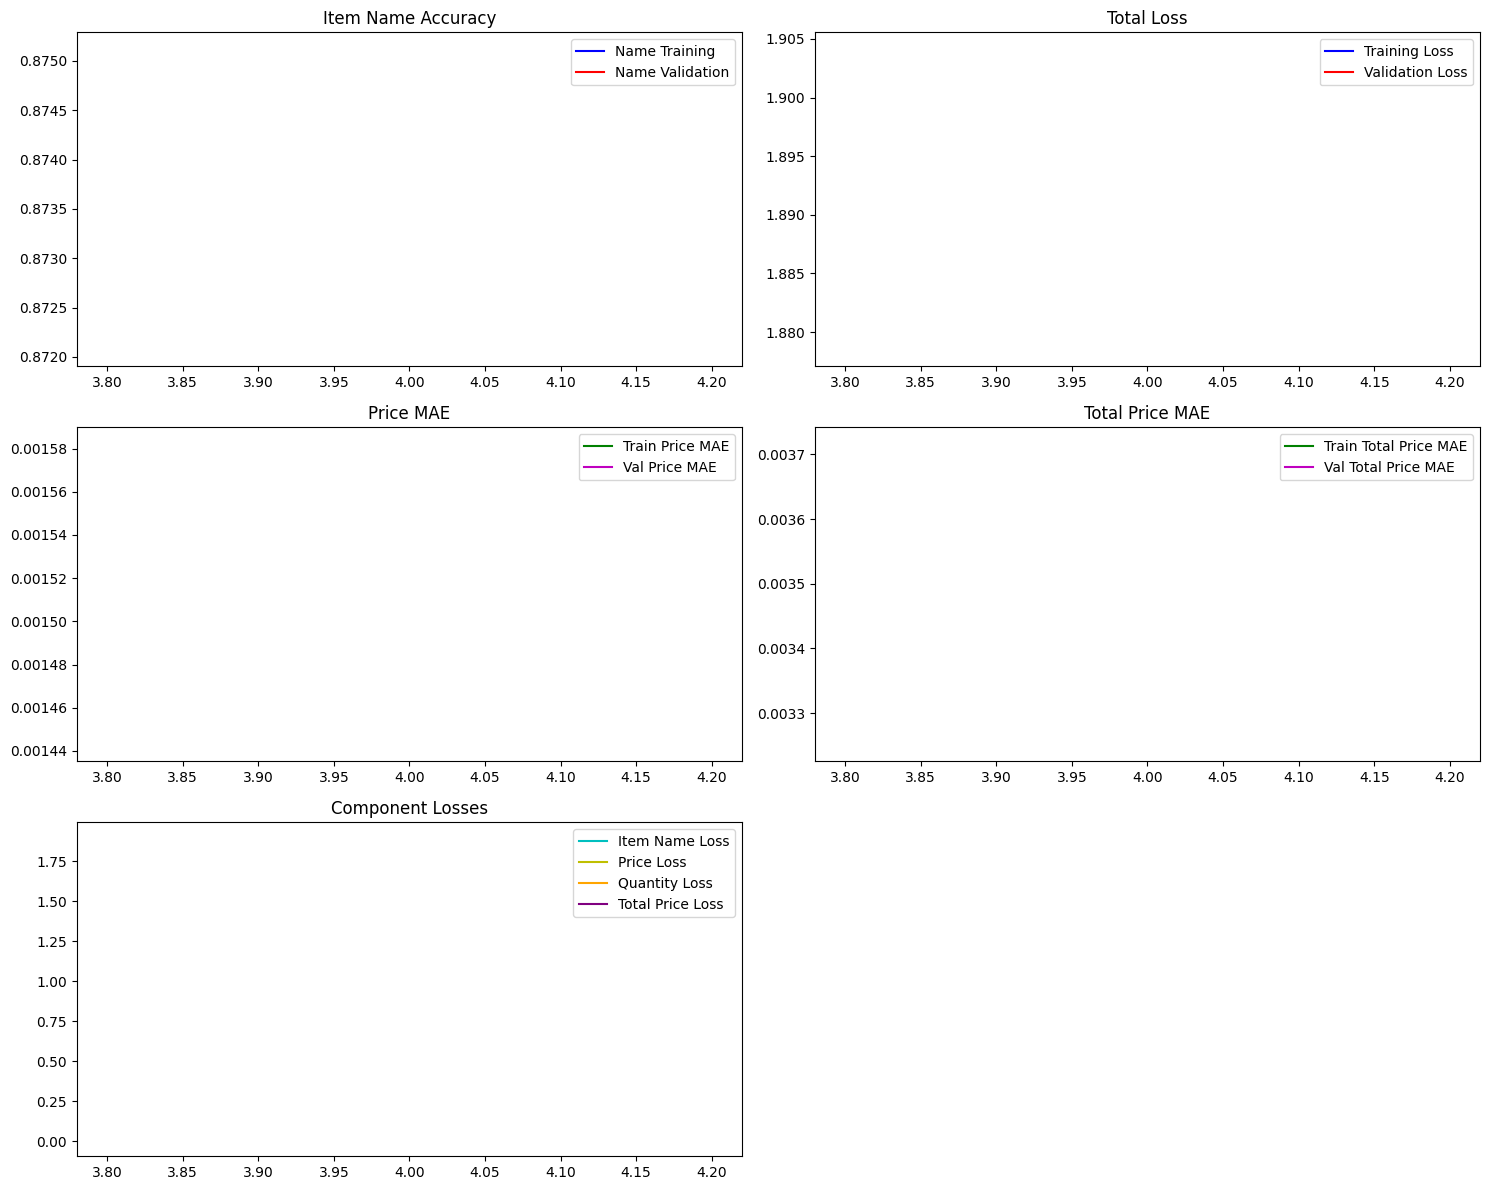

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training log
log_data = pd.read_csv("training_log.csv")

plt.figure(figsize=(15, 12))

# Plot Item Name Accuracy
plt.subplot(3, 2, 1)
plt.plot(log_data['epoch'], log_data['item_name_accuracy'], 'b-', label='Name Training')
plt.plot(log_data['epoch'], log_data['val_item_name_accuracy'], 'r-', label='Name Validation')
plt.title('Item Name Accuracy')
plt.legend()

# Plot Total Loss
plt.subplot(3, 2, 2)
plt.plot(log_data['epoch'], log_data['loss'], 'b-', label='Training Loss')
plt.plot(log_data['epoch'], log_data['val_loss'], 'r-', label='Validation Loss')
plt.title('Total Loss')
plt.legend()

# Plot Regression Performance (Price MAE)
plt.subplot(3, 2, 3)
plt.plot(log_data['epoch'], log_data['price_final_mae'], 'g-', label='Train Price MAE')
plt.plot(log_data['epoch'], log_data['val_price_final_mae'], 'm-', label='Val Price MAE')
plt.title('Price MAE')
plt.legend()

# Plot Regression Performance (Total Price MAE)
plt.subplot(3, 2, 4)
plt.plot(log_data['epoch'], log_data['total_price_mae'], 'g-', label='Train Total Price MAE')
plt.plot(log_data['epoch'], log_data['val_total_price_mae'], 'm-', label='Val Total Price MAE')
plt.title('Total Price MAE')
plt.legend()

# Plot Component Losses
plt.subplot(3, 2, 5)
plt.plot(log_data['epoch'], log_data['item_name_loss'], 'c-', label='Item Name Loss')
plt.plot(log_data['epoch'], log_data['price_final_loss'], 'y-', label='Price Loss')
plt.plot(log_data['epoch'], log_data['quantity_final_loss'], 'orange', label='Quantity Loss')
plt.plot(log_data['epoch'], log_data['total_price_loss'], 'purple', label='Total Price Loss')
plt.title('Component Losses')
plt.legend()

plt.tight_layout()
plt.show()


In [211]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from googleapiclient.http import MediaFileUpload
import os

In [212]:
# Save Model
model.save("image_invoice_resnet50v2_v2.h5")
model.save("image_invoice_resnet50v2_v2.keras")
print("Model saved successfully!")

Model saved successfully!


In [ ]:
drive_service = build('drive', 'v3')

folder_id = "1a0i_DpxSo1RnkT7ZjUr_AdawVvW2vBSX"  # Dapatkan dari URL Google Drive folder kamu

# # # Zip folder SavedModel
# # shutil.make_archive("final_faster_rcnn_resnet50v2", 'zip', "final_faster_rcnn_resnet50v2")

# # file_metadata = {
# #     "name": "final_faster_rcnn_resnet50v2",
# #     "parents": [folder_id]
# # }
# # media_savedmodel = MediaFileUpload("final_faster_rcnn_resnet50v2", mimetype="application/octet-stream")
# # file_savedmodel = drive_service.files().create(body=file_metadata_savedmodel, media_body=media_savedmodel, fields="id").execute()
# # print(f"File uploaded with ID: {file_savedmodel.get('id')}")

file_metadata = {
    "name": "image_invoice_resnet50v2_v2.keras",
    "parents": [folder_id]
}
media = MediaFileUpload("image_invoice_resnet50v2_v2.keras", mimetype="application/octet-stream")

file = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()
print(f"File uploaded with ID: {file.get('id')}")

file_metadata_h5 = {
    "name": "image_invoice_resnet50v2_v2.h5",
    "parents": [folder_id]
}
media_h5 = MediaFileUpload("image_invoice_resnet50v2_v2.h5", mimetype="application/octet-stream")

file_h5 = drive_service.files().create(body=file_metadata_h5, media_body=media_h5, fields="id").execute()
print(f"File uploaded with ID: {file_h5.get('id')}")

In [ ]:
# import shutil

# # Zip file keras
# shutil.make_archive("final_faster_rcnn_resnet50v2", 'zip', root_dir='.', base_dir='final_faster_rcnn_resnet50v2.keras')

# # Kemudian upload ZIP-nya, bukan file `.keras`
# media = MediaFileUpload("final_faster_rcnn_resnet50v2.zip", mimetype="application/zip")
# file_metadata = {
#     "name": "final_faster_rcnn_resnet50v2.zip",
#     "parents": [folder_id]
# }
# file = drive_service.files().create(body=file_metadata, media_body=media, fields="id").execute()
# print(f"File uploaded with ID: {file.get('id')}")